In [24]:
# ==== CONFIG =====
# Change ONLY this line:
DOMAIN = "money-heist"    # <-- your domain name

# ===== AUTO PATH BUILDING =====
from pathlib import Path
import json
import random
import textwrap
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)

# Root of repo — adjust if notebook lives elsewhere
REPO_ROOT = Path("..").resolve()

# Data folders adapt to domain automatically
EMB_DIR = REPO_ROOT / "data" / "embeddings"
PROCESSED_DIR = REPO_ROOT / "data" / "processed"

EMB_PATH = EMB_DIR / f"spans_{DOMAIN}.npy"
ID_PATH = EMB_DIR / f"spans_{DOMAIN}.index_ids.npy"
MODEL_INFO_PATH = EMB_DIR / f"model_info_{DOMAIN}.json"
SPANS_PATH = PROCESSED_DIR / f"spans_{DOMAIN}.csv"

print("Using domain:", DOMAIN)
print("Embeddings path:", EMB_PATH)
print("Index IDs path:", ID_PATH)
print("Spans CSV path:", SPANS_PATH)
print("Model info path:", MODEL_INFO_PATH)
print("====== File Check ======")
print("Embeddings exist:", EMB_PATH.exists())
print("Index IDs exist:", ID_PATH.exists())
print("Spans CSV exists:", SPANS_PATH.exists())
print("Model info exists:", MODEL_INFO_PATH.exists())

Using domain: money-heist
Embeddings path: /data/sundeep/Fandom_SI/data/embeddings/spans_money-heist.npy
Index IDs path: /data/sundeep/Fandom_SI/data/embeddings/spans_money-heist.index_ids.npy
Spans CSV path: /data/sundeep/Fandom_SI/data/processed/spans_money-heist.csv
Model info path: /data/sundeep/Fandom_SI/data/embeddings/model_info_money-heist.json
====== File Check ======
Embeddings exist: True
Index IDs exist: True
Spans CSV exists: True
Model info exists: True


In [25]:
embeddings = np.load(EMB_PATH)
index_ids = np.load(ID_PATH, allow_pickle=True)

print("Embeddings shape:", embeddings.shape)
print("Index IDs shape:", index_ids.shape)
print("dtype of index_ids:", index_ids.dtype)

Embeddings shape: (3189, 384)
Index IDs shape: (3189,)
dtype of index_ids: object


In [26]:
if MODEL_INFO_PATH.exists():
    with MODEL_INFO_PATH.open("r") as f:
        model_info = json.load(f)
    model_info
else:
    print("No model_info found for domain:", DOMAIN)
    model_info = {}

In [27]:
print("Any NaNs?", np.isnan(embeddings).any())
print("Any Infs?", np.isinf(embeddings).any())

norms = np.linalg.norm(embeddings, axis=1)
print("Norm Stats:")
print(pd.Series(norms).describe())

Any NaNs? False
Any Infs? False
Norm Stats:
count    3.189000e+03
mean     1.000000e+00
std      3.163436e-08
min      9.999999e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64


In [28]:
df_spans = pd.read_csv(SPANS_PATH)
print("Columns:", df_spans.columns.tolist())
print("Num spans:", len(df_spans))

assert "span_id" in df_spans.columns, "Expected column span_id to map embeddings."
assert "text" in df_spans.columns, "Expected span text stored in column 'text'."

Columns: ['span_id', 'article_id', 'page_name', 'title', 'section', 'span_index', 'start_char', 'end_char', 'len_chars', 'num_sents', 'text', 'url', 'source_path']
Num spans: 3189


In [29]:
embeddings = np.load(EMB_PATH)
index_ids = np.load(ID_PATH, allow_pickle=True)

print("Embeddings shape:", embeddings.shape)
print("Index IDs shape:", index_ids.shape)
print("Example index_ids[:5]:", index_ids[:5])

df_spans = pd.read_csv(SPANS_PATH)
print("Columns:", df_spans.columns.tolist())
print("Num spans:", len(df_spans))

# ✅ Make sure both are strings so they match
index_ids = np.array(index_ids, dtype=str)
df_spans["span_id"] = df_spans["span_id"].astype(str)

# Build mapping span_id -> row index
spanid_to_row = {sid: i for i, sid in enumerate(df_spans["span_id"].tolist())}

missing = [sid for sid in index_ids if sid not in spanid_to_row]
print("Missing span_ids in spans.csv:", len(missing))
print("Sample missing:", missing[:10])

Embeddings shape: (3189, 384)
Index IDs shape: (3189,)
Example index_ids[:5]: ['money-heist_span_0000001' 'money-heist_span_0000002'
 'money-heist_span_0000003' 'money-heist_span_0000004'
 'money-heist_span_0000005']
Columns: ['span_id', 'article_id', 'page_name', 'title', 'section', 'span_index', 'start_char', 'end_char', 'len_chars', 'num_sents', 'text', 'url', 'source_path']
Num spans: 3189
Missing span_ids in spans.csv: 0
Sample missing: []


In [30]:
def get_span_text_by_id(span_id: str):
    row_idx = spanid_to_row.get(span_id, None)
    if row_idx is None:
        return None
    return str(df_spans.iloc[row_idx]["text"])

In [31]:
def get_neighbors(embeddings, index_ids, query_idx, top_k=6):
    query_vec = embeddings[query_idx : query_idx + 1]
    sims = cosine_similarity(query_vec, embeddings)[0]

    sorted_idx = np.argsort(-sims)

    neighbors = []
    for rank in range(top_k):
        idx = sorted_idx[rank]
        neighbors.append(
            {
                "rank": rank,
                "array_idx": int(idx),
                "span_id": index_ids[idx],   # string
                "similarity": float(sims[idx]),
            }
        )
    return neighbors

In [32]:
N_EXAMPLES = 5
N_NEIGHBORS = 6

num_vecs = embeddings.shape[0]
random_indices = random.sample(range(num_vecs), k=min(N_EXAMPLES, num_vecs))

for q_idx in random_indices:
    print("\n" + "="*80)
    span_id = index_ids[q_idx]  # string like "money-heist_span_0002702"
    print(f"[Query idx {q_idx}] span_id = {span_id}")
    
    q_text = get_span_text_by_id(span_id)
    print("\n[QUERY TEXT]")
    print(textwrap.fill(q_text or "(no text found)", width=100))
    
    neighbors = get_neighbors(embeddings, index_ids, q_idx, top_k=N_NEIGHBORS)
    
    for n in neighbors:
        neighbor_span_id = n["span_id"]   # this is a string now
        print(f"\n--- Neighbor rank {n['rank']} | span_id={neighbor_span_id} | sim={n['similarity']:.4f}")
        neighbor_text = get_span_text_by_id(neighbor_span_id)
        print(textwrap.fill(neighbor_text or "(no text found)", width=100))


[Query idx 3033] span_id = money-heist_span_0003034

[QUERY TEXT]
Stockholm revive Arturo after shooting him. At last Arturo got the pulse. Stockholm demands to free
Arturo so that he can take to the hospital. Palmero was convinced to release Arturo by Lisbon.

--- Neighbor rank 0 | span_id=money-heist_span_0002876 | sim=1.0000
Stockholm revive Arturo after shooting him. At last Arturo got the pulse. Stockholm demands to free
Arturo so that he can take to the hospital. Palmero was convinced to release Arturo by Lisbon.

--- Neighbor rank 1 | span_id=money-heist_span_0003016 | sim=1.0000
Stockholm revive Arturo after shooting him. At last Arturo got the pulse. Stockholm demands to free
Arturo so that he can take to the hospital. Palmero was convinced to release Arturo by Lisbon.

--- Neighbor rank 2 | span_id=money-heist_span_0003034 | sim=1.0000
Stockholm revive Arturo after shooting him. At last Arturo got the pulse. Stockholm demands to free
Arturo so that he can take to the hospita

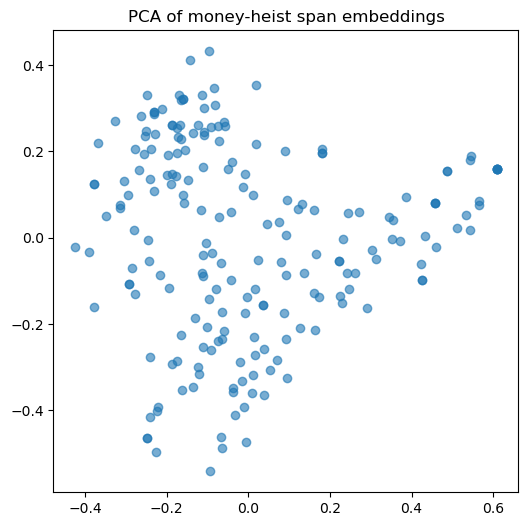

In [33]:
SAMPLE = min(200, len(embeddings))
sample_idx = random.sample(range(len(embeddings)), k=SAMPLE)
emb_sample = embeddings[sample_idx]

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb_sample)

plt.figure(figsize=(6,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.6)
plt.title(f"PCA of {DOMAIN} span embeddings")
plt.show()